# Tune non-stationary algorithms

Here we create and save the data for tuning of non-stationary algorithms.
For tuning we use a subset (5000 points) of data similar to that used in experiment 7. But the costs don't change
in the tuning region. Saeed said it's the correct way to do tuning.

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
from src import evaluation
from src import costs
from src.plotting.costs import plot_costs

In [3]:
np.random.seed(42)

In [4]:
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [7]:
df_num = df.astype('category')

In [8]:
df_num['final evaluation']

0         recommend
1          priority
2         not_recom
3         recommend
4          priority
            ...    
12955    spec_prior
12956     not_recom
12957    spec_prior
12958    spec_prior
12959     not_recom
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [9]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [10]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [11]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [12]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,1,1,1,1,1,1,1,2,2
1,1,1,1,1,1,1,1,3,4
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,2,2,2
4,1,1,1,1,1,1,2,3,4
...,...,...,...,...,...,...,...,...,...
12955,3,5,4,4,3,2,2,3,5
12956,3,5,4,4,3,2,2,1,1
12957,3,5,4,4,3,2,3,2,5
12958,3,5,4,4,3,2,3,3,5


In [13]:
# final evaluation is target variable

all_contexts = df_num.drop(['social', 'finance', 'final evaluation'], axis=1)

# In this notebook also drop children column. In next we'll try how it goes together with this column.

all_contexts = all_contexts.drop(['housing'], axis=1).to_numpy()

In [14]:
all_contexts.shape

(12960, 5)

In [15]:
all_contexts

array([[1, 1, 1, 1, 2],
       [1, 1, 1, 1, 3],
       [1, 1, 1, 1, 1],
       ...,
       [3, 5, 4, 4, 2],
       [3, 5, 4, 4, 3],
       [3, 5, 4, 4, 1]], dtype=int8)

In [16]:
y = df_num['final evaluation']

In [17]:
y.value_counts()

1    4320
4    4266
5    4044
3     328
2       2
Name: final evaluation, dtype: int64

In [18]:
# Drop arms with small rewards

In [19]:
# Values meaning:
# not recommended (1)
# recommend (2)
# very recommend (3)
# priority acceptance (4)
# special priority (5)

In [20]:
(y != 3) & (y != 2)

0        False
1         True
2         True
3        False
4         True
         ...  
12955     True
12956     True
12957     True
12958     True
12959     True
Name: final evaluation, Length: 12960, dtype: bool

In [21]:
all_contexts = all_contexts[(y != 3) & (y != 2)]

In [22]:
y = y[(y != 3) & (y != 2)]

In [23]:
y.value_counts()

1    4320
4    4266
5    4044
Name: final evaluation, dtype: int64

In [24]:
np.sum(np.where(y == 3, 1, 0))

0

In [25]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [26]:
all_rewards

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [27]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320, 4266, 4044])

In [28]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [29]:
all_rewards.shape[0]

12630

In [30]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, 11000),
    slice(11000, all_contexts.shape[0]),
]

In [31]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [32]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 11000, 12630]

In [33]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.34204276, 0.33776722, 0.32019002])

In [34]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [35]:
new_contexts.shape, new_rewards.shape

((12630, 5), (12630, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.0
Min expected reward for arm 3: 0.0


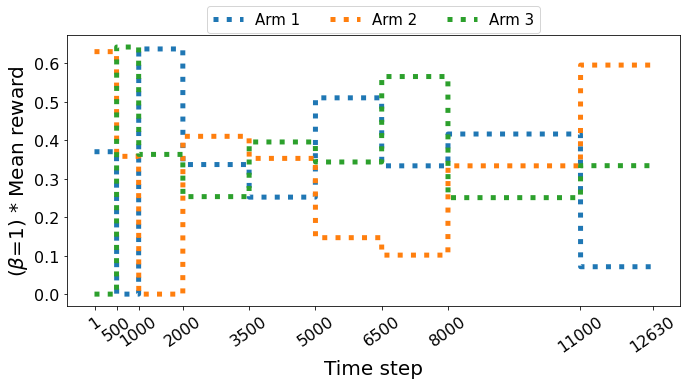

In [36]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


### Non-stationarity in costs

In [37]:
cost_change_points = [5000, 7000, 9000, 11000]
interval_count = len(cost_change_points) + 1

In [38]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.03, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [39]:
interval_means

[array([0.0174908 , 0.02901429, 0.02463988, 0.02197317, 0.01312037]),
 array([0.01311989, 0.01116167, 0.02732352, 0.0220223 , 0.02416145]),
 array([0.01041169, 0.0293982 , 0.02664885, 0.01424678, 0.0136365 ]),
 array([0.01366809, 0.01608484, 0.02049513, 0.0186389 , 0.01582458]),
 array([0.02223706, 0.01278988, 0.01584289, 0.01732724, 0.0191214 ])]

In [40]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [41]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

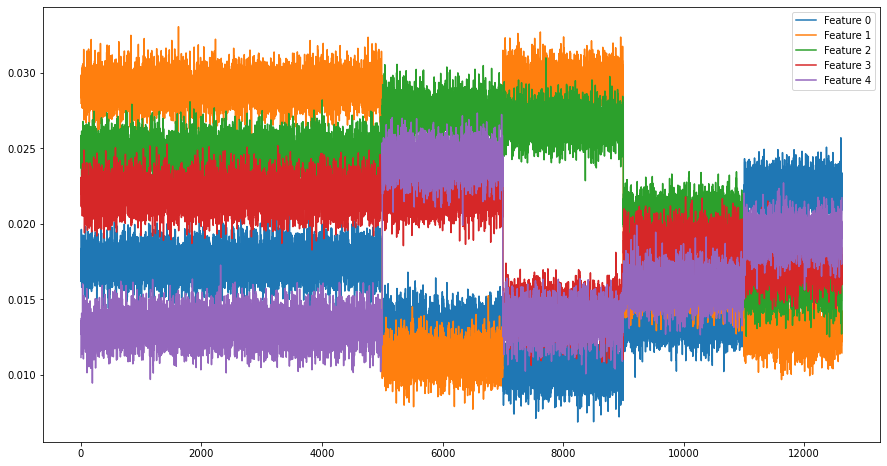

In [42]:
plot_costs(get_costs(), new_contexts.shape[0])

In [43]:
costs_obj = get_costs()

In [44]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [45]:
costs_vector.shape

(12630, 5)

## Plot expected reward minus sum of costs

In [46]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.11385448529640274
Min expected gain for arm 2: -0.11317324339246093
Min expected gain for arm 3: -0.11181856805171389


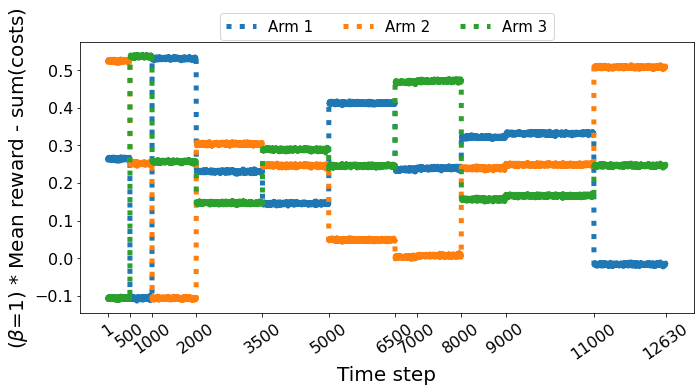

In [47]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [48]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = all_change_point_values
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

# Save the data

In [49]:
data = (new_contexts, new_rewards, costs_vector)

In [50]:
import pickle

with open('dataset/nursery/nursery_ctx_five.pickle', 'wb') as f:
    pickle.dump(data, f)

## Tuning

In [51]:
TUNING_NUM_OF_TRIALS = 5000
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

In [52]:
np.random.seed(42)

### PS-LinUCB

In [53]:
ps_linucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for omega in [100, 300, 500, 750, 1000, 1250, 1500, 1750, 2000]:
        for delta in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]:
            gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
            for i in range(NUM_REPETITIONS):

                ps_linucb = algorithms.PSLinUCB(
                    n_trials=TUNING_NUM_OF_TRIALS,
                    context_dimension=new_contexts.shape[1],
                    n_arms=new_rewards.shape[1],
                    alpha=alpha,
                    omega=omega,
                    delta=delta,
                )


                gain_pslinucb = evaluation.evaluate_on_synthetic_data(
                    ps_linucb,
                    new_contexts,
                    new_rewards,
                    costs_vector,
                    beta=BETA,
                    stop_after=TUNING_NUM_OF_TRIALS,
                )
                change_points = ps_linucb.change_points
                gains[i, :] = gain_pslinucb

            gain_pslinucb = np.mean(gains, axis=0)
            ps_linucb_gains[(alpha, omega, delta)] = gain_pslinucb

PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 1905.5993981778174
	Total reward: 2437.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 1905.5993981778174
	Total reward: 2437.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 1905.5993981778174
	Total reward: 2437.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 1905.5993981778174
	Total reward: 2437.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 1905.5993981778174
	Total reward: 2437.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=100, delta=0.005)
Beta = 1
Total gain: 1905.5993981778174
	Total reward: 2437.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.001, omega=100, 

PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 1186.5993981778254
	Total reward: 1718.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 1186.5993981778254
	Total reward: 1718.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 1186.5993981778254
	Total reward: 1718.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 1186.5993981778254
	Total reward: 1718.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 1186.5993981778254
	Total reward: 1718.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 1186.5993981778254
	Total reward: 1718.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=300, delta=

PSLinUCB (alpha=0.001, omega=500, delta=0.05)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1311.5993981778213
	Total reward: 1843.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1311.5993981778213
	Total reward: 1843.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1311.5993981778213
	Total reward: 1843.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1311.5993981778213
	Total reward: 1843.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1311.5993981778213
	Total reward: 1843.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.001, omega=500, delta=0.15)

PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1394.5993981778217
	Total reward: 1926.0
	Total cost: 531.4006018221771
Execution time: 1.2s
PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1394.5993981778217
	Total reward: 1926.0
	Total cost: 531.4006018221771
Execution time: 1.4s
PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1394.5993981778217
	Total reward: 1926.0
	Total cost: 531.4006018221771
Execution time: 1.4s
PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1394.5993981778217
	Total reward: 1926.0
	Total cost: 531.4006018221771
Execution time: 1.3s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta = 1
Total gain: 1396.5993981778215
	Total reward: 1928.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta = 1
Total gain: 1396.5993981778215
	Total reward: 1928.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1000, delta

PSLinUCB (alpha=0.001, omega=1250, delta=0.005)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1250, delta=0.005)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1250, delta=0.005)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.001, omega=12

PSLinUCB (alpha=0.001, omega=1500, delta=0.03)
Beta = 1
Total gain: 1386.5993981778215
	Total reward: 1918.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=1500, delta=0.03)
Beta = 1
Total gain: 1386.5993981778215
	Total reward: 1918.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1386.5993981778215
	Total reward: 1918.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1386.5993981778215
	Total reward: 1918.0
	Total cost: 531.4006018221771
Execution time: 1.2s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1386.5993981778215
	Total reward: 1918.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1386.5993981778215
	Total reward: 1918.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.001, omega=1500,

PSLinUCB (alpha=0.001, omega=1750, delta=0.1)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1750, 

PSLinUCB (alpha=0.005, omega=100, delta=0.001)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=100, delta=0.001)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=100, delta=0.001)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=100, delta=0.001)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.005, omega=100, delta=0.001)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.005, omega=100, 

PSLinUCB (alpha=0.005, omega=300, delta=0.01)
Beta = 1
Total gain: 1295.599398177822
	Total reward: 1827.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.005, omega=300, delta=0.01)
Beta = 1
Total gain: 1295.599398177822
	Total reward: 1827.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.005, omega=300, delta=0.01)
Beta = 1
Total gain: 1295.599398177822
	Total reward: 1827.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 1291.599398177822
	Total reward: 1823.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 1291.599398177822
	Total reward: 1823.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 1291.599398177822
	Total reward: 1823.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)


PSLinUCB (alpha=0.005, omega=500, delta=0.05)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=500, delta=0.15)

PSLinUCB (alpha=0.005, omega=750, delta=0.2)
Beta = 1
Total gain: 1395.5993981778217
	Total reward: 1927.0
	Total cost: 531.4006018221771
Execution time: 1.5s
PSLinUCB (alpha=0.005, omega=750, delta=0.2)
Beta = 1
Total gain: 1395.5993981778217
	Total reward: 1927.0
	Total cost: 531.4006018221771
Execution time: 1.5s
PSLinUCB (alpha=0.005, omega=750, delta=0.2)
Beta = 1
Total gain: 1395.5993981778217
	Total reward: 1927.0
	Total cost: 531.4006018221771
Execution time: 1.4s
PSLinUCB (alpha=0.005, omega=750, delta=0.2)
Beta = 1
Total gain: 1395.5993981778217
	Total reward: 1927.0
	Total cost: 531.4006018221771
Execution time: 1.5s
PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 1398.5993981778215
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 1398.5993981778215
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1000, delta

PSLinUCB (alpha=0.005, omega=1250, delta=0.005)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1250, delta=0.005)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1250, delta=0.005)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.005, omega=1250, delta=0.01)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1250, delta=0.01)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1250, delta=0.01)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=12

PSLinUCB (alpha=0.005, omega=1500, delta=0.03)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.005, omega=1500, delta=0.03)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1500, delta=0.05)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.005, omega=1500, delta=0.05)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.005, omega=1500, delta=0.05)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1500, delta=0.05)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1500,

PSLinUCB (alpha=0.005, omega=1750, delta=0.1)
Beta = 1
Total gain: 1391.5993981778215
	Total reward: 1923.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.005, omega=1750, delta=0.15)
Beta = 1
Total gain: 1391.5993981778215
	Total reward: 1923.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1750, delta=0.15)
Beta = 1
Total gain: 1391.5993981778215
	Total reward: 1923.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1750, delta=0.15)
Beta = 1
Total gain: 1391.5993981778215
	Total reward: 1923.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.005, omega=1750, delta=0.15)
Beta = 1
Total gain: 1391.5993981778215
	Total reward: 1923.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1750, delta=0.15)
Beta = 1
Total gain: 1391.5993981778215
	Total reward: 1923.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.005, omega=1750, 

PSLinUCB (alpha=0.01, omega=100, delta=0.001)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.01, omega=100, delta=0.001)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=100, delta=0.001)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=100, delta=0.001)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=100, delta=0.001)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=100, delta=0.005)
Beta = 1
Total gain: 1906.5993981778174
	Total reward: 2438.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=100, delta=0

PSLinUCB (alpha=0.01, omega=300, delta=0.01)
Beta = 1
Total gain: 1297.5993981778217
	Total reward: 1829.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.01, omega=300, delta=0.01)
Beta = 1
Total gain: 1297.5993981778217
	Total reward: 1829.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.01, omega=300, delta=0.01)
Beta = 1
Total gain: 1297.5993981778217
	Total reward: 1829.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.01, omega=300, delta=0.03)
Beta = 1
Total gain: 1294.5993981778217
	Total reward: 1826.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.01, omega=300, delta=0.03)
Beta = 1
Total gain: 1294.5993981778217
	Total reward: 1826.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=300, delta=0.03)
Beta = 1
Total gain: 1294.5993981778217
	Total reward: 1826.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=300, delta=0.03)
B

PSLinUCB (alpha=0.01, omega=500, delta=0.05)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=500, delta=0.1)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=500, delta=0.1)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=500, delta=0.1)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=500, delta=0.1)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.01, omega=500, delta=0.1)
Beta = 1
Total gain: 1312.5993981778215
	Total reward: 1844.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=500, delta=0.15)
Beta =

PSLinUCB (alpha=0.01, omega=750, delta=0.2)
Beta = 1
Total gain: 1395.5993981778217
	Total reward: 1927.0
	Total cost: 531.4006018221771
Execution time: 1.3s
PSLinUCB (alpha=0.01, omega=750, delta=0.2)
Beta = 1
Total gain: 1395.5993981778217
	Total reward: 1927.0
	Total cost: 531.4006018221771
Execution time: 1.4s
PSLinUCB (alpha=0.01, omega=750, delta=0.2)
Beta = 1
Total gain: 1395.5993981778217
	Total reward: 1927.0
	Total cost: 531.4006018221771
Execution time: 1.4s
PSLinUCB (alpha=0.01, omega=750, delta=0.2)
Beta = 1
Total gain: 1395.5993981778217
	Total reward: 1927.0
	Total cost: 531.4006018221771
Execution time: 1.3s
PSLinUCB (alpha=0.01, omega=1000, delta=0.001)
Beta = 1
Total gain: 1398.5993981778215
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.01, omega=1000, delta=0.001)
Beta = 1
Total gain: 1398.5993981778215
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.01, omega=1000, delta=0.001)

PSLinUCB (alpha=0.01, omega=1250, delta=0.005)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.01, omega=1250, delta=0.005)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1250, delta=0.01)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.01, omega=1250, delta=0.01)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.01, omega=1250, delta=0.01)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1250, delta=0.01)
Beta = 1
Total gain: 1313.5993981778215
	Total reward: 1845.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.01, omega=1250, delt

PSLinUCB (alpha=0.01, omega=1500, delta=0.05)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1500, delta=0.05)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.01, omega=1500, delta=0.05)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1500, delta=0.05)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.01, omega=1500, delta=0.05)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1500, delta=0.1)
Beta = 1
Total gain: 1387.5993981778213
	Total reward: 1919.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.01, omega=1500, delta=0

PSLinUCB (alpha=0.01, omega=1750, delta=0.15)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.01, omega=1750, delta=0.15)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.01, omega=1750, delta=0.15)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1750, delta=0.2)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1750, delta=0.2)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1750, delta=0.2)
Beta = 1
Total gain: 1392.5993981778215
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.01, omega=1750, delta=0.2

PSLinUCB (alpha=0.05, omega=100, delta=0.001)
Beta = 1
Total gain: 2248.599398177816
	Total reward: 2780.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=100, delta=0.005)
Beta = 1
Total gain: 2248.599398177816
	Total reward: 2780.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.05, omega=100, delta=0.005)
Beta = 1
Total gain: 2248.599398177816
	Total reward: 2780.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=100, delta=0.005)
Beta = 1
Total gain: 2248.599398177816
	Total reward: 2780.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=100, delta=0.005)
Beta = 1
Total gain: 2248.599398177816
	Total reward: 2780.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=100, delta=0.005)
Beta = 1
Total gain: 2248.599398177816
	Total reward: 2780.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=100, delta=0.01)
B

PSLinUCB (alpha=0.05, omega=300, delta=0.03)
Beta = 1
Total gain: 1240.5993981778265
	Total reward: 1772.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.05, omega=300, delta=0.03)
Beta = 1
Total gain: 1240.5993981778265
	Total reward: 1772.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.05, omega=300, delta=0.03)
Beta = 1
Total gain: 1240.5993981778265
	Total reward: 1772.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.05, omega=300, delta=0.03)
Beta = 1
Total gain: 1240.5993981778265
	Total reward: 1772.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=300, delta=0.05)
Beta = 1
Total gain: 1240.5993981778265
	Total reward: 1772.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.05, omega=300, delta=0.05)
Beta = 1
Total gain: 1240.5993981778265
	Total reward: 1772.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.05, omega=300, delta=0.05)
B

PSLinUCB (alpha=0.05, omega=500, delta=0.1)
Beta = 1
Total gain: 1432.5993981778224
	Total reward: 1964.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=500, delta=0.1)
Beta = 1
Total gain: 1432.5993981778224
	Total reward: 1964.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.05, omega=500, delta=0.15)
Beta = 1
Total gain: 1366.5993981778236
	Total reward: 1898.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=500, delta=0.15)
Beta = 1
Total gain: 1366.5993981778236
	Total reward: 1898.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=500, delta=0.15)
Beta = 1
Total gain: 1366.5993981778236
	Total reward: 1898.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=500, delta=0.15)
Beta = 1
Total gain: 1366.5993981778236
	Total reward: 1898.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=500, delta=0.15)
Bet

PSLinUCB (alpha=0.05, omega=1000, delta=0.001)
Beta = 1
Total gain: 1604.5993981778229
	Total reward: 2136.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=1000, delta=0.001)
Beta = 1
Total gain: 1604.5993981778229
	Total reward: 2136.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=1000, delta=0.001)
Beta = 1
Total gain: 1604.5993981778229
	Total reward: 2136.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=1000, delta=0.001)
Beta = 1
Total gain: 1604.5993981778229
	Total reward: 2136.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=1000, delta=0.001)
Beta = 1
Total gain: 1604.5993981778229
	Total reward: 2136.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=1000, delta=0.005)
Beta = 1
Total gain: 1604.5993981778229
	Total reward: 2136.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.05, omega=1000, 

PSLinUCB (alpha=0.05, omega=1250, delta=0.01)
Beta = 1
Total gain: 1366.5993981778236
	Total reward: 1898.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=1250, delta=0.01)
Beta = 1
Total gain: 1366.5993981778236
	Total reward: 1898.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.05, omega=1250, delta=0.01)
Beta = 1
Total gain: 1366.5993981778236
	Total reward: 1898.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=1250, delta=0.03)
Beta = 1
Total gain: 1366.5993981778236
	Total reward: 1898.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.05, omega=1250, delta=0.03)
Beta = 1
Total gain: 1366.5993981778236
	Total reward: 1898.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=1250, delta=0.03)
Beta = 1
Total gain: 1366.5993981778236
	Total reward: 1898.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.05, omega=1250, delta=

PSLinUCB (alpha=0.05, omega=1500, delta=0.05)
Beta = 1
Total gain: 1416.599398177823
	Total reward: 1948.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=1500, delta=0.1)
Beta = 1
Total gain: 1416.599398177823
	Total reward: 1948.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=1500, delta=0.1)
Beta = 1
Total gain: 1416.599398177823
	Total reward: 1948.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=1500, delta=0.1)
Beta = 1
Total gain: 1416.599398177823
	Total reward: 1948.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.05, omega=1500, delta=0.1)
Beta = 1
Total gain: 1416.599398177823
	Total reward: 1948.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=1500, delta=0.1)
Beta = 1
Total gain: 1416.599398177823
	Total reward: 1948.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=1500, delta=0.15)
Beta 

PSLinUCB (alpha=0.05, omega=1750, delta=0.2)
Beta = 1
Total gain: 1448.5993981778229
	Total reward: 1980.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=1750, delta=0.2)
Beta = 1
Total gain: 1448.5993981778229
	Total reward: 1980.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.05, omega=1750, delta=0.2)
Beta = 1
Total gain: 1448.5993981778229
	Total reward: 1980.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=1750, delta=0.2)
Beta = 1
Total gain: 1448.5993981778229
	Total reward: 1980.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=2000, delta=0.001)
Beta = 1
Total gain: 1448.5993981778229
	Total reward: 1980.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=2000, delta=0.001)
Beta = 1
Total gain: 1448.5993981778229
	Total reward: 1980.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=2000, delta=0.

PSLinUCB (alpha=0.1, omega=100, delta=0.005)
Beta = 1
Total gain: 3037.5993981778165
	Total reward: 3569.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=100, delta=0.005)
Beta = 1
Total gain: 3037.5993981778165
	Total reward: 3569.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Beta = 1
Total gain: 3037.5993981778165
	Total reward: 3569.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Beta = 1
Total gain: 3037.5993981778165
	Total reward: 3569.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Beta = 1
Total gain: 3037.5993981778165
	Total reward: 3569.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Beta = 1
Total gain: 3037.5993981778165
	Total reward: 3569.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Beta =

PSLinUCB (alpha=0.1, omega=300, delta=0.05)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=300, delta=0.05)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=300, delta=0.05)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=300, delta=0.05)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=300, delta=0.05)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=300, delta=0.1)
Beta = 1
Total gain: 1392.5993981778233
	Total reward: 1924.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=300, delta=0.1)
Beta = 1
T

PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Beta = 1
Total gain: 1397.5993981778233
	Total reward: 1929.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Beta = 1
Total gain: 1397.5993981778233
	Total reward: 1929.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Beta = 1
Total gain: 1397.5993981778233
	Total reward: 1929.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.1, omega=500, delta=0.2)
Beta = 1
Total gain: 1397.5993981778233
	Total reward: 1929.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.1, omega=500, delta=0.2)
Beta = 1
Total gain: 1397.5993981778233
	Total reward: 1929.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.1, omega=500, delta=0.2)
Beta = 1
Total gain: 1397.5993981778233
	Total reward: 1929.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.1, omega=500, delta=0.2)
Beta = 1
Tot

PSLinUCB (alpha=0.1, omega=1000, delta=0.001)
Beta = 1
Total gain: 1475.5993981778233
	Total reward: 2007.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1000, delta=0.005)
Beta = 1
Total gain: 1475.5993981778233
	Total reward: 2007.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1000, delta=0.005)
Beta = 1
Total gain: 1475.5993981778233
	Total reward: 2007.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1000, delta=0.005)
Beta = 1
Total gain: 1475.5993981778233
	Total reward: 2007.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1000, delta=0.005)
Beta = 1
Total gain: 1475.5993981778233
	Total reward: 2007.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1000, delta=0.005)
Beta = 1
Total gain: 1475.5993981778233
	Total reward: 2007.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1000, delta=0

PSLinUCB (alpha=0.1, omega=1250, delta=0.03)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.03)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.03)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.1, omega=1250, delta=0.03)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.05)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.05)
Beta = 1
Total gain: 1398.5993981778233
	Total reward: 1930.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.05)
B

PSLinUCB (alpha=0.1, omega=1500, delta=0.1)
Beta = 1
Total gain: 1449.5993981778233
	Total reward: 1981.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1500, delta=0.1)
Beta = 1
Total gain: 1449.5993981778233
	Total reward: 1981.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1500, delta=0.15)
Beta = 1
Total gain: 1449.5993981778233
	Total reward: 1981.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1500, delta=0.15)
Beta = 1
Total gain: 1449.5993981778233
	Total reward: 1981.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.1, omega=1500, delta=0.15)
Beta = 1
Total gain: 1449.5993981778233
	Total reward: 1981.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.1, omega=1500, delta=0.15)
Beta = 1
Total gain: 1449.5993981778233
	Total reward: 1981.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1500, delta=0.15)
Bet

PSLinUCB (alpha=0.1, omega=2000, delta=0.001)
Beta = 1
Total gain: 1490.5993981778233
	Total reward: 2022.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=2000, delta=0.001)
Beta = 1
Total gain: 1490.5993981778233
	Total reward: 2022.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=2000, delta=0.001)
Beta = 1
Total gain: 1490.5993981778233
	Total reward: 2022.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=2000, delta=0.001)
Beta = 1
Total gain: 1490.5993981778233
	Total reward: 2022.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=2000, delta=0.001)
Beta = 1
Total gain: 1490.5993981778233
	Total reward: 2022.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=2000, delta=0.005)
Beta = 1
Total gain: 1490.5993981778233
	Total reward: 2022.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=2000, delta=0

PSLinUCB (alpha=0.2, omega=100, delta=0.01)
Beta = 1
Total gain: 2476.5993981778165
	Total reward: 3008.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=100, delta=0.01)
Beta = 1
Total gain: 2476.5993981778165
	Total reward: 3008.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=100, delta=0.01)
Beta = 1
Total gain: 2476.5993981778165
	Total reward: 3008.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.2, omega=100, delta=0.03)
Beta = 1
Total gain: 2998.5993981778174
	Total reward: 3530.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=100, delta=0.03)
Beta = 1
Total gain: 2998.5993981778174
	Total reward: 3530.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=100, delta=0.03)
Beta = 1
Total gain: 2998.5993981778174
	Total reward: 3530.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=100, delta=0.03)
Beta = 1

PSLinUCB (alpha=0.2, omega=300, delta=0.05)
Beta = 1
Total gain: 2583.5993981778183
	Total reward: 3115.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=300, delta=0.1)
Beta = 1
Total gain: 2585.5993981778183
	Total reward: 3117.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=300, delta=0.1)
Beta = 1
Total gain: 2585.5993981778183
	Total reward: 3117.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=300, delta=0.1)
Beta = 1
Total gain: 2585.5993981778183
	Total reward: 3117.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=300, delta=0.1)
Beta = 1
Total gain: 2585.5993981778183
	Total reward: 3117.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=300, delta=0.1)
Beta = 1
Total gain: 2585.5993981778183
	Total reward: 3117.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=300, delta=0.15)
Beta = 1
Tota

PSLinUCB (alpha=0.2, omega=500, delta=0.2)
Beta = 1
Total gain: 2388.5993981778165
	Total reward: 2920.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.2, omega=500, delta=0.2)
Beta = 1
Total gain: 2388.5993981778165
	Total reward: 2920.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.2, omega=500, delta=0.2)
Beta = 1
Total gain: 2388.5993981778165
	Total reward: 2920.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.2, omega=500, delta=0.2)
Beta = 1
Total gain: 2388.5993981778165
	Total reward: 2920.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.2, omega=750, delta=0.001)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=750, delta=0.001)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=750, delta=0.001)
Beta = 1


PSLinUCB (alpha=0.2, omega=1000, delta=0.005)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=1000, delta=0.005)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=1000, delta=0.01)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1000, delta=0.01)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1000, delta=0.01)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=1000, delta=0.01)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1000, delta=0.01)

PSLinUCB (alpha=0.2, omega=1250, delta=0.05)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1250, delta=0.05)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1250, delta=0.05)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1250, delta=0.05)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=1250, delta=0.05)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=1250, delta=0.1)
Beta = 1
Total gain: 2334.5993981778165
	Total reward: 2866.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=1250, delta=0.1)
Bet

PSLinUCB (alpha=0.2, omega=1500, delta=0.15)
Beta = 1
Total gain: 2308.5993981778165
	Total reward: 2840.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1500, delta=0.15)
Beta = 1
Total gain: 2308.5993981778165
	Total reward: 2840.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=1500, delta=0.15)
Beta = 1
Total gain: 2308.5993981778165
	Total reward: 2840.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=1500, delta=0.2)
Beta = 1
Total gain: 2308.5993981778165
	Total reward: 2840.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1500, delta=0.2)
Beta = 1
Total gain: 2308.5993981778165
	Total reward: 2840.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1500, delta=0.2)
Beta = 1
Total gain: 2308.5993981778165
	Total reward: 2840.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1500, delta=0.2)
Beta 

PSLinUCB (alpha=0.2, omega=2000, delta=0.001)
Beta = 1
Total gain: 2259.5993981778156
	Total reward: 2791.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=2000, delta=0.005)
Beta = 1
Total gain: 2259.5993981778156
	Total reward: 2791.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=2000, delta=0.005)
Beta = 1
Total gain: 2259.5993981778156
	Total reward: 2791.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=2000, delta=0.005)
Beta = 1
Total gain: 2259.5993981778156
	Total reward: 2791.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.2, omega=2000, delta=0.005)
Beta = 1
Total gain: 2259.5993981778156
	Total reward: 2791.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=2000, delta=0.005)
Beta = 1
Total gain: 2259.5993981778156
	Total reward: 2791.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=2000, delta=0

PSLinUCB (alpha=0.3, omega=100, delta=0.03)
Beta = 1
Total gain: 3012.5993981778165
	Total reward: 3544.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=100, delta=0.03)
Beta = 1
Total gain: 3012.5993981778165
	Total reward: 3544.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=100, delta=0.03)
Beta = 1
Total gain: 3012.5993981778165
	Total reward: 3544.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=100, delta=0.03)
Beta = 1
Total gain: 3012.5993981778165
	Total reward: 3544.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=100, delta=0.05)
Beta = 1
Total gain: 3105.5993981778165
	Total reward: 3637.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=100, delta=0.05)
Beta = 1
Total gain: 3105.5993981778165
	Total reward: 3637.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=100, delta=0.05)
Beta = 1

PSLinUCB (alpha=0.3, omega=300, delta=0.1)
Beta = 1
Total gain: 2603.5993981778183
	Total reward: 3135.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=300, delta=0.1)
Beta = 1
Total gain: 2603.5993981778183
	Total reward: 3135.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=300, delta=0.15)
Beta = 1
Total gain: 2603.5993981778183
	Total reward: 3135.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.3, omega=300, delta=0.15)
Beta = 1
Total gain: 2603.5993981778183
	Total reward: 3135.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.3, omega=300, delta=0.15)
Beta = 1
Total gain: 2603.5993981778183
	Total reward: 3135.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.3, omega=300, delta=0.15)
Beta = 1
Total gain: 2603.5993981778183
	Total reward: 3135.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.3, omega=300, delta=0.15)
Beta = 1
T

PSLinUCB (alpha=0.3, omega=750, delta=0.001)
Beta = 1
Total gain: 2472.5993981778174
	Total reward: 3004.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=750, delta=0.001)
Beta = 1
Total gain: 2472.5993981778174
	Total reward: 3004.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=750, delta=0.001)
Beta = 1
Total gain: 2472.5993981778174
	Total reward: 3004.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=750, delta=0.001)
Beta = 1
Total gain: 2472.5993981778174
	Total reward: 3004.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=750, delta=0.001)
Beta = 1
Total gain: 2472.5993981778174
	Total reward: 3004.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=750, delta=0.005)
Beta = 1
Total gain: 2472.5993981778174
	Total reward: 3004.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=750, delta=0.005)
B

PSLinUCB (alpha=0.3, omega=1000, delta=0.01)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=1000, delta=0.01)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1000, delta=0.01)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1000, delta=0.03)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=1000, delta=0.03)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1000, delta=0.03)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1000, delta=0.03)
B

PSLinUCB (alpha=0.3, omega=1250, delta=0.05)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1250, delta=0.1)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1250, delta=0.1)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=1250, delta=0.1)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1250, delta=0.1)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1250, delta=0.1)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1250, delta=0.15)
Beta =

PSLinUCB (alpha=0.3, omega=1500, delta=0.2)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1500, delta=0.2)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=1500, delta=0.2)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=1500, delta=0.2)
Beta = 1
Total gain: 2473.5993981778174
	Total reward: 3005.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1750, delta=0.001)
Beta = 1
Total gain: 2429.5993981778183
	Total reward: 2961.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1750, delta=0.001)
Beta = 1
Total gain: 2429.5993981778183
	Total reward: 2961.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1750, delta=0.001)
Be

PSLinUCB (alpha=0.3, omega=2000, delta=0.005)
Beta = 1
Total gain: 2429.5993981778183
	Total reward: 2961.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=2000, delta=0.005)
Beta = 1
Total gain: 2429.5993981778183
	Total reward: 2961.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=2000, delta=0.01)
Beta = 1
Total gain: 2429.5993981778183
	Total reward: 2961.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=2000, delta=0.01)
Beta = 1
Total gain: 2429.5993981778183
	Total reward: 2961.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=2000, delta=0.01)
Beta = 1
Total gain: 2429.5993981778183
	Total reward: 2961.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=2000, delta=0.01)
Beta = 1
Total gain: 2429.5993981778183
	Total reward: 2961.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=2000, delta=0.01)

PSLinUCB (alpha=0.4, omega=100, delta=0.05)
Beta = 1
Total gain: 3137.5993981778183
	Total reward: 3669.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=100, delta=0.05)
Beta = 1
Total gain: 3137.5993981778183
	Total reward: 3669.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=100, delta=0.05)
Beta = 1
Total gain: 3137.5993981778183
	Total reward: 3669.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=100, delta=0.05)
Beta = 1
Total gain: 3137.5993981778183
	Total reward: 3669.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=100, delta=0.05)
Beta = 1
Total gain: 3137.5993981778183
	Total reward: 3669.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total gain: 2666.5993981778156
	Total reward: 3198.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
T

PSLinUCB (alpha=0.4, omega=300, delta=0.15)
Beta = 1
Total gain: 2588.5993981778183
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.4, omega=300, delta=0.15)
Beta = 1
Total gain: 2588.5993981778183
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.4, omega=300, delta=0.15)
Beta = 1
Total gain: 2588.5993981778183
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.4, omega=300, delta=0.2)
Beta = 1
Total gain: 2588.5993981778183
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.4, omega=300, delta=0.2)
Beta = 1
Total gain: 2588.5993981778183
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.4, omega=300, delta=0.2)
Beta = 1
Total gain: 2588.5993981778183
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.4, omega=300, delta=0.2)
Beta = 1
Tot

PSLinUCB (alpha=0.4, omega=750, delta=0.001)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=750, delta=0.005)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=750, delta=0.005)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=750, delta=0.005)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=750, delta=0.005)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=750, delta=0.005)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=750, delta=0.01)
Be

PSLinUCB (alpha=0.4, omega=1000, delta=0.03)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1000, delta=0.03)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1000, delta=0.03)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1000, delta=0.03)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1000, delta=0.05)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1000, delta=0.05)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=1000, delta=0.05)
B

PSLinUCB (alpha=0.4, omega=1250, delta=0.1)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1250, delta=0.1)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1250, delta=0.15)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1250, delta=0.15)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1250, delta=0.15)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1250, delta=0.15)
Beta = 1
Total gain: 2324.5993981778165
	Total reward: 2856.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1250, delta=0.15)
Bet

PSLinUCB (alpha=0.4, omega=1750, delta=0.001)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=1750, delta=0.001)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=1750, delta=0.001)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1750, delta=0.001)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1750, delta=0.001)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1750, delta=0.005)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1750, delta=0

PSLinUCB (alpha=0.4, omega=2000, delta=0.01)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=2000, delta=0.01)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=2000, delta=0.01)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=2000, delta=0.03)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=2000, delta=0.03)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=2000, delta=0.03)
Beta = 1
Total gain: 2269.5993981778156
	Total reward: 2801.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=2000, delta=0.03)
B

PSLinUCB (alpha=0.5, omega=100, delta=0.05)
Beta = 1
Total gain: 2705.59939817782
	Total reward: 3237.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 3085.5993981778174
	Total reward: 3617.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 3085.5993981778174
	Total reward: 3617.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 3085.5993981778174
	Total reward: 3617.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 3085.5993981778174
	Total reward: 3617.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 3085.5993981778174
	Total reward: 3617.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=100, delta=0.15)
Beta = 1
Total 

PSLinUCB (alpha=0.5, omega=300, delta=0.2)
Beta = 1
Total gain: 2676.599398177821
	Total reward: 3208.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.5, omega=300, delta=0.2)
Beta = 1
Total gain: 2676.599398177821
	Total reward: 3208.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.5, omega=300, delta=0.2)
Beta = 1
Total gain: 2676.599398177821
	Total reward: 3208.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.5, omega=500, delta=0.001)
Beta = 1
Total gain: 2557.59939817782
	Total reward: 3089.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=500, delta=0.001)
Beta = 1
Total gain: 2557.59939817782
	Total reward: 3089.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=500, delta=0.001)
Beta = 1
Total gain: 2557.59939817782
	Total reward: 3089.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=500, delta=0.001)
Beta = 1
Total g

PSLinUCB (alpha=0.5, omega=750, delta=0.01)
Beta = 1
Total gain: 2533.59939817782
	Total reward: 3065.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=750, delta=0.01)
Beta = 1
Total gain: 2533.59939817782
	Total reward: 3065.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=750, delta=0.01)
Beta = 1
Total gain: 2533.59939817782
	Total reward: 3065.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=750, delta=0.01)
Beta = 1
Total gain: 2533.59939817782
	Total reward: 3065.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=750, delta=0.01)
Beta = 1
Total gain: 2533.59939817782
	Total reward: 3065.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=750, delta=0.03)
Beta = 1
Total gain: 2533.59939817782
	Total reward: 3065.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=750, delta=0.03)
Beta = 1
Total gain:

PSLinUCB (alpha=0.5, omega=1000, delta=0.05)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1000, delta=0.05)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=1000, delta=0.1)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=1000, delta=0.1)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1000, delta=0.1)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1000, delta=0.1)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=1000, delta=0.1)
Beta = 1
Total gai

PSLinUCB (alpha=0.5, omega=1250, delta=0.2)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1250, delta=0.2)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1250, delta=0.2)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1250, delta=0.2)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=1500, delta=0.001)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=1500, delta=0.001)
Beta = 1
Total gain: 2534.59939817782
	Total reward: 3066.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1500, delta=0.001)
Beta = 1
Total

PSLinUCB (alpha=0.5, omega=1750, delta=0.005)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1750, delta=0.01)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1750, delta=0.01)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1750, delta=0.01)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1750, delta=0.01)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1750, delta=0.01)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1750, delta=0.03)


PSLinUCB (alpha=0.5, omega=2000, delta=0.05)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=2000, delta=0.05)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=2000, delta=0.05)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=2000, delta=0.05)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=2000, delta=0.1)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=2000, delta=0.1)
Beta = 1
Total gain: 2463.5993981778174
	Total reward: 2995.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=2000, delta=0.1)
Beta

PSLinUCB (alpha=0.6, omega=100, delta=0.15)
Beta = 1
Total gain: 3437.5993981778174
	Total reward: 3969.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=100, delta=0.15)
Beta = 1
Total gain: 3437.5993981778174
	Total reward: 3969.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Beta = 1
Total gain: 3159.5993981778183
	Total reward: 3691.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Beta = 1
Total gain: 3159.5993981778183
	Total reward: 3691.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Beta = 1
Total gain: 3159.5993981778183
	Total reward: 3691.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Beta = 1
Total gain: 3159.5993981778183
	Total reward: 3691.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Beta = 1
Tota

PSLinUCB (alpha=0.6, omega=500, delta=0.005)
Beta = 1
Total gain: 2554.59939817782
	Total reward: 3086.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=500, delta=0.005)
Beta = 1
Total gain: 2554.59939817782
	Total reward: 3086.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.6, omega=500, delta=0.005)
Beta = 1
Total gain: 2554.59939817782
	Total reward: 3086.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=500, delta=0.005)
Beta = 1
Total gain: 2554.59939817782
	Total reward: 3086.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=500, delta=0.01)
Beta = 1
Total gain: 2554.59939817782
	Total reward: 3086.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=500, delta=0.01)
Beta = 1
Total gain: 2554.59939817782
	Total reward: 3086.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=500, delta=0.01)
Beta = 1
Total g

PSLinUCB (alpha=0.6, omega=750, delta=0.03)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=750, delta=0.1)
Beta = 1
Total gain: 

PSLinUCB (alpha=0.6, omega=1000, delta=0.15)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.6, omega=1000, delta=0.15)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.6, omega=1000, delta=0.15)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.6, omega=1000, delta=0.2)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 1.2s
PSLinUCB (alpha=0.6, omega=1000, delta=0.2)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 1.4s
PSLinUCB (alpha=0.6, omega=1000, delta=0.2)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.6, omega=1000, delta=0.2)
Beta = 1
Total ga

PSLinUCB (alpha=0.6, omega=1500, delta=0.005)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=1500, delta=0.005)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=1500, delta=0.005)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1500, delta=0.005)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1500, delta=0.005)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.6, omega=1500, delta=0.01)
Beta = 1
Total gain: 2532.59939817782
	Total reward: 3064.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=1500, delta=0.01)
Beta = 1

PSLinUCB (alpha=0.6, omega=1750, delta=0.03)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=1750, delta=0.03)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=1750, delta=0.03)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.6, omega=1750, delta=0.05)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=1750, delta=0.05)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=1750, delta=0.05)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.6, omega=1750, delta=0.05)
B

PSLinUCB (alpha=0.6, omega=2000, delta=0.1)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=2000, delta=0.15)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=2000, delta=0.15)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.6, omega=2000, delta=0.15)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=2000, delta=0.15)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=2000, delta=0.15)
Beta = 1
Total gain: 2462.5993981778174
	Total reward: 2994.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=2000, delta=0.2)
Bet

PSLinUCB (alpha=0.7, omega=300, delta=0.001)
Beta = 1
Total gain: 2588.5993981778174
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=300, delta=0.001)
Beta = 1
Total gain: 2588.5993981778174
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=300, delta=0.001)
Beta = 1
Total gain: 2588.5993981778174
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=300, delta=0.001)
Beta = 1
Total gain: 2588.5993981778174
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=300, delta=0.005)
Beta = 1
Total gain: 2588.5993981778174
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=300, delta=0.005)
Beta = 1
Total gain: 2588.5993981778174
	Total reward: 3120.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=300, delta=0.005)
B

PSLinUCB (alpha=0.7, omega=500, delta=0.01)
Beta = 1
Total gain: 2480.5993981778183
	Total reward: 3012.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=500, delta=0.01)
Beta = 1
Total gain: 2480.5993981778183
	Total reward: 3012.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=500, delta=0.03)
Beta = 1
Total gain: 2480.5993981778183
	Total reward: 3012.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=500, delta=0.03)
Beta = 1
Total gain: 2480.5993981778183
	Total reward: 3012.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=500, delta=0.03)
Beta = 1
Total gain: 2480.5993981778183
	Total reward: 3012.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=500, delta=0.03)
Beta = 1
Total gain: 2480.5993981778183
	Total reward: 3012.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=500, delta=0.03)
Beta = 1

PSLinUCB (alpha=0.7, omega=750, delta=0.1)
Beta = 1
Total gain: 2448.5993981778183
	Total reward: 2980.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=750, delta=0.1)
Beta = 1
Total gain: 2448.5993981778183
	Total reward: 2980.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=750, delta=0.1)
Beta = 1
Total gain: 2448.5993981778183
	Total reward: 2980.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=750, delta=0.1)
Beta = 1
Total gain: 2448.5993981778183
	Total reward: 2980.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=750, delta=0.1)
Beta = 1
Total gain: 2448.5993981778183
	Total reward: 2980.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=750, delta=0.15)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 1.5s
PSLinUCB (alpha=0.7, omega=750, delta=0.15)
Beta = 1
Tota

PSLinUCB (alpha=0.7, omega=1000, delta=0.2)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.7, omega=1000, delta=0.2)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 0.9s
PSLinUCB (alpha=0.7, omega=1000, delta=0.2)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.7, omega=1250, delta=0.001)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.7, omega=1250, delta=0.001)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=1250, delta=0.001)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=1250, delta=0.001)


PSLinUCB (alpha=0.7, omega=1500, delta=0.005)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.7, omega=1500, delta=0.01)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=1500, delta=0.01)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=1500, delta=0.01)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=1500, delta=0.01)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=1500, delta=0.01)
Beta = 1
Total gain: 2450.5993981778183
	Total reward: 2982.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=1500, delta=0.03)


PSLinUCB (alpha=0.7, omega=1750, delta=0.05)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.8s
PSLinUCB (alpha=0.7, omega=1750, delta=0.05)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=1750, delta=0.05)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=1750, delta=0.05)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=1750, delta=0.1)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=1750, delta=0.1)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.7, omega=1750, delta=0.1)
Beta

PSLinUCB (alpha=0.7, omega=2000, delta=0.15)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=2000, delta=0.15)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Beta = 1
Total gain: 2397.5993981778174
	Total reward: 2929.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Beta =

PSLinUCB (alpha=0.8, omega=300, delta=0.005)
Beta = 1
Total gain: 2620.5993981778192
	Total reward: 3152.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.8, omega=300, delta=0.005)
Beta = 1
Total gain: 2620.5993981778192
	Total reward: 3152.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.8, omega=300, delta=0.005)
Beta = 1
Total gain: 2620.5993981778192
	Total reward: 3152.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.8, omega=300, delta=0.005)
Beta = 1
Total gain: 2620.5993981778192
	Total reward: 3152.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.8, omega=300, delta=0.005)
Beta = 1
Total gain: 2620.5993981778192
	Total reward: 3152.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.8, omega=300, delta=0.01)
Beta = 1
Total gain: 2620.5993981778192
	Total reward: 3152.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.8, omega=300, delta=0.01)
Bet

PSLinUCB (alpha=0.8, omega=500, delta=0.03)
Beta = 1
Total gain: 2511.5993981778174
	Total reward: 3043.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.8, omega=500, delta=0.03)
Beta = 1
Total gain: 2511.5993981778174
	Total reward: 3043.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.8, omega=500, delta=0.03)
Beta = 1
Total gain: 2511.5993981778174
	Total reward: 3043.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=500, delta=0.05)
Beta = 1
Total gain: 2511.5993981778174
	Total reward: 3043.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=500, delta=0.05)
Beta = 1
Total gain: 2511.5993981778174
	Total reward: 3043.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=500, delta=0.05)
Beta = 1
Total gain: 2511.5993981778174
	Total reward: 3043.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=500, delta=0.05)
Beta = 1

PSLinUCB (alpha=0.8, omega=750, delta=0.1)
Beta = 1
Total gain: 2491.5993981778174
	Total reward: 3023.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.8, omega=750, delta=0.15)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.8, omega=750, delta=0.15)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.8, omega=750, delta=0.15)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.8, omega=750, delta=0.15)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 1.0s
PSLinUCB (alpha=0.8, omega=750, delta=0.15)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.8, omega=750, delta=0.2)
Beta = 1
T

PSLinUCB (alpha=0.8, omega=1250, delta=0.001)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1250, delta=0.001)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=1250, delta=0.001)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1250, delta=0.001)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1250, delta=0.005)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1250, delta=0.005)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1250, delta=0

PSLinUCB (alpha=0.8, omega=1500, delta=0.01)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=1500, delta=0.01)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=1500, delta=0.03)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1500, delta=0.03)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.8, omega=1500, delta=0.03)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1500, delta=0.03)
Beta = 1
Total gain: 2492.5993981778174
	Total reward: 3024.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=1500, delta=0.03)
B

PSLinUCB (alpha=0.8, omega=1750, delta=0.1)
Beta = 1
Total gain: 2437.5993981778174
	Total reward: 2969.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1750, delta=0.1)
Beta = 1
Total gain: 2437.5993981778174
	Total reward: 2969.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=1750, delta=0.1)
Beta = 1
Total gain: 2437.5993981778174
	Total reward: 2969.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1750, delta=0.1)
Beta = 1
Total gain: 2437.5993981778174
	Total reward: 2969.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1750, delta=0.1)
Beta = 1
Total gain: 2437.5993981778174
	Total reward: 2969.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.8, omega=1750, delta=0.15)
Beta = 1
Total gain: 2437.5993981778174
	Total reward: 2969.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=1750, delta=0.15)
Beta =

PSLinUCB (alpha=0.8, omega=2000, delta=0.2)
Beta = 1
Total gain: 2437.5993981778174
	Total reward: 2969.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.8, omega=2000, delta=0.2)
Beta = 1
Total gain: 2437.5993981778174
	Total reward: 2969.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.8, omega=2000, delta=0.2)
Beta = 1
Total gain: 2437.5993981778174
	Total reward: 2969.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=100, delta=0.001)
Beta = 1
Total gain: 3750.5993981778165
	Total reward: 4282.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=100, delta=0.001)
Beta = 1
Total gain: 3750.5993981778165
	Total reward: 4282.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=100, delta=0.001)
Beta = 1
Total gain: 3750.5993981778165
	Total reward: 4282.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=100, delta=0.001)
Beta

PSLinUCB (alpha=0.9, omega=300, delta=0.005)
Beta = 1
Total gain: 2645.599398177821
	Total reward: 3177.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=300, delta=0.01)
Beta = 1
Total gain: 2645.599398177821
	Total reward: 3177.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.9, omega=300, delta=0.01)
Beta = 1
Total gain: 2645.599398177821
	Total reward: 3177.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=300, delta=0.01)
Beta = 1
Total gain: 2645.599398177821
	Total reward: 3177.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.9, omega=300, delta=0.01)
Beta = 1
Total gain: 2645.599398177821
	Total reward: 3177.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=300, delta=0.01)
Beta = 1
Total gain: 2645.599398177821
	Total reward: 3177.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.9, omega=300, delta=0.03)
Beta = 1
Tota

PSLinUCB (alpha=0.9, omega=500, delta=0.05)
Beta = 1
Total gain: 2531.5993981778183
	Total reward: 3063.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=500, delta=0.05)
Beta = 1
Total gain: 2531.5993981778183
	Total reward: 3063.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=500, delta=0.05)
Beta = 1
Total gain: 2531.5993981778183
	Total reward: 3063.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=500, delta=0.1)
Beta = 1
Total gain: 2531.5993981778183
	Total reward: 3063.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=500, delta=0.1)
Beta = 1
Total gain: 2531.5993981778183
	Total reward: 3063.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=500, delta=0.1)
Beta = 1
Total gain: 2531.5993981778183
	Total reward: 3063.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=500, delta=0.1)
Beta = 1
Tot

PSLinUCB (alpha=0.9, omega=750, delta=0.15)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.2)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.2)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.2)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.2)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 1.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.2)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 1.3s
PSLinUCB (alpha=0.9, omega=1000, delta=0.001)
Beta = 1
To

PSLinUCB (alpha=0.9, omega=1250, delta=0.005)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=1250, delta=0.005)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=1250, delta=0.005)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=1250, delta=0.005)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=1250, delta=0.01)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=1250, delta=0.01)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=1250, delta=0.0

PSLinUCB (alpha=0.9, omega=1500, delta=0.03)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=1500, delta=0.03)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=1500, delta=0.05)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=1500, delta=0.05)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=1500, delta=0.05)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=1500, delta=0.05)
Beta = 1
Total gain: 2512.5993981778183
	Total reward: 3044.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=1500, delta=0.05)
B

PSLinUCB (alpha=0.9, omega=1750, delta=0.15)
Beta = 1
Total gain: 2443.5993981778174
	Total reward: 2975.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=1750, delta=0.15)
Beta = 1
Total gain: 2443.5993981778174
	Total reward: 2975.0
	Total cost: 531.4006018221771
Execution time: 0.7s
PSLinUCB (alpha=0.9, omega=1750, delta=0.15)
Beta = 1
Total gain: 2443.5993981778174
	Total reward: 2975.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=1750, delta=0.15)
Beta = 1
Total gain: 2443.5993981778174
	Total reward: 2975.0
	Total cost: 531.4006018221771
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=1750, delta=0.15)
Beta = 1
Total gain: 2443.5993981778174
	Total reward: 2975.0
	Total cost: 531.4006018221771
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=1750, delta=0.2)
Beta = 1
Total gain: 2443.5993981778174
	Total reward: 2975.0
	Total cost: 531.4006018221771
Execution time: 0.6s
PSLinUCB (alpha=0.9, omega=1750, delta=0.2)
Bet

In [54]:
last_gains = {k:v[-1] for k,v in ps_linucb_gains.items()}
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb

(0.9, 100, 0.05)

### Evaluate tuned

In [55]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=best_alpha_ps_linucb,
        omega=best_omega_ps_linucb,
        delta=best_delta_ps_linucb,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.9, omega=100, delta=0.05)
Beta = 1
Total gain: 9200.854210684824
	Total reward: 10428.0
	Total cost: 1227.1457893151387
Execution time: 1.3s
PSLinUCB (alpha=0.9, omega=100, delta=0.05)
Beta = 1
Total gain: 9200.854210684824
	Total reward: 10428.0
	Total cost: 1227.1457893151387
Execution time: 1.3s
PSLinUCB (alpha=0.9, omega=100, delta=0.05)
Beta = 1
Total gain: 9200.854210684824
	Total reward: 10428.0
	Total cost: 1227.1457893151387
Execution time: 1.3s
PSLinUCB (alpha=0.9, omega=100, delta=0.05)
Beta = 1
Total gain: 9200.854210684824
	Total reward: 10428.0
	Total cost: 1227.1457893151387
Execution time: 1.3s
PSLinUCB (alpha=0.9, omega=100, delta=0.05)
Beta = 1
Total gain: 9200.854210684824
	Total reward: 10428.0
	Total cost: 1227.1457893151387
Execution time: 1.2s
Average gain: 9200.854210684824


### Algorithm1 is tuned separately

Using script3 in cloud. This is because Algorithm1 is much more computationally demanding.

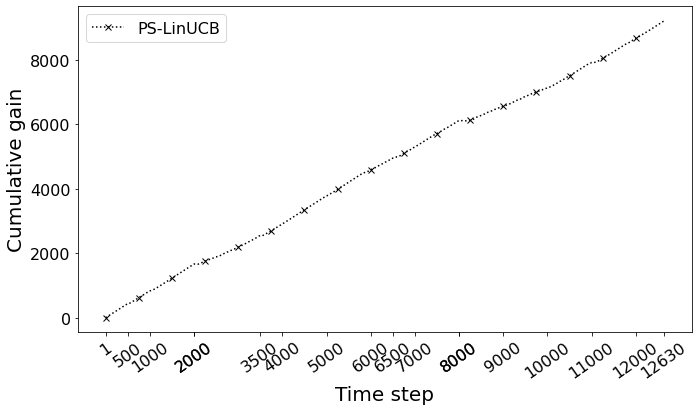

In [56]:
plot_gains({
    'PS-LinUCB': gain_pslinucb,
},
)


In [57]:
gain_pslinucb[5000]

3783.4926871357266